In [ ]:
import numpy as np
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics

%matplotlib inline

In [ ]:
print(tf.__version__)
print(tf.keras.__version__)

2.6.0
2.6.0


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1QtuAY57-FVeMiDHExgYN4-kEgGElQYH-',
dest_path='content/asl_alphabets.zip',
unzip=True)

In [ ]:
ROOT_DIR = 'content/asl_alphabets/'
TRAINING_DIR = 'content/asl_alphabets/train'
TESTING_DIR = 'content/asl_alphabets/test'
TRAINING_INFO = 'content/asl_alphabets/Training_set.csv'
TESTING_INFO = 'content/asl_alphabets/Testing_set.csv'

In [ ]:
data_info = pd.read_csv(TRAINING_INFO)

In [ ]:
pd.concat([data_info.head(), data_info.tail()])

,filename,label
0,Image_1.jpg,B
1,Image_2.jpg,P
2,Image_3.jpg,J
3,Image_4.jpg,T
4,Image_5.jpg,B
60895,Image_60896.jpg,S
60896,Image_60897.jpg,I
60897,Image_60898.jpg,X
60898,Image_60899.jpg,Q
60899,Image_60900.jpg,K


In [ ]:
len(data_info['label'].unique())
labels = data_info['label'].unique()
labels.sort()
print(labels)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'del' 'nothing' 'space']


In [ ]:
data_info = pd.get_dummies(data_info, columns=['label'])

In [ ]:
data_info.head()

,filename,label_A,label_B,label_C,label_D,label_E,label_F,label_G,label_H,label_I,label_J,label_K,label_L,label_M,label_N,label_O,label_P,label_Q,label_R,label_S,label_T,label_U,label_V,label_W,label_X,label_Y,label_Z,label_del,label_nothing,label_space
0,Image_1.jpg,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Image_2.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Image_3.jpg,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Image_4.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Image_5.jpg,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = data_info[['filename']].to_numpy().reshape(-1,)
y = data_info.drop(['filename'], axis=1).to_numpy()

In [ ]:
y[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [ ]:
def images_to_array(DIRECTORY, TRAIN_SIZE, TEST_SIZE):
    images_train = np.zeros(TRAIN_SIZE)
    images_test = np.zeros(TEST_SIZE)
    for idx, image in enumerate(X[:TRAIN_SIZE[0]]):
        path = os.path.join(DIRECTORY, image)
        image = cv2.imread(path, 0)
        image = cv2.resize(image, (TRAIN_SIZE[1], TRAIN_SIZE[2]), interpolation=cv2.INTER_AREA)
        image = image.reshape(TRAIN_SIZE[1], TRAIN_SIZE[2], 1)
        images_train[idx, :, :, :] = image/255.
    for idx, image in enumerate(X[TRAIN_SIZE[0]:]):
        path = os.path.join(DIRECTORY, image)
        image = cv2.imread(path, 0)
        image = cv2.resize(image, (TEST_SIZE[1], TEST_SIZE[2]), interpolation=cv2.INTER_AREA)
        image = image.reshape(TEST_SIZE[1], TEST_SIZE[2], 1)
        images_test[idx, :, :, :] = image/255.

    return images_train, images_test

In [ ]:
train_size = (50000, 100, 100, 1)
test_size = (10900, 100, 100, 1)
X_train, X_test = images_to_array(TRAINING_DIR, train_size, test_size)

In [ ]:
y_train, y_test = y[:train_size[0]], y[train_size[0]:]

In [ ]:
y_train.shape

(50000, 29)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 3, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(29, activation='softmax')
])

In [ ]:
print(y_train.shape, X_train.shape)

(50000, 29) (50000, 100, 100, 1)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 256)       2

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test,y_test))

Epoch 1/50
1563/1563 [==============================] - 101s 58ms/step - loss: 1.4494 - acc: 0.5459 - val_loss: 0.3519 - val_acc: 0.8890
Epoch 2/50
1563/1563 [==============================] - 90s 57ms/step - loss: 0.3932 - acc: 0.8649 - val_loss: 0.1519 - val_acc: 0.9522
Epoch 3/50
1563/1563 [==============================] - 89s 57ms/step - loss: 0.2434 - acc: 0.9184 - val_loss: 0.0887 - val_acc: 0.9704
Epoch 4/50
1563/1563 [==============================] - 89s 57ms/step - loss: 0.1759 - acc: 0.9405 - val_loss: 0.0610 - val_acc: 0.9810
Epoch 5/50
1563/1563 [==============================] - 89s 57ms/step - loss: 0.1457 - acc: 0.9520 - val_loss: 0.0569 - val_acc: 0.9810
Epoch 6/50
1563/1563 [==============================] - 89s 57ms/step - loss: 0.1256 - acc: 0.9608 - val_loss: 0.0675 - val_acc: 0.9808
Epoch 7/50
1563/1563 [==============================] - 89s 57ms/step - loss: 0.1096 - acc: 0.9654 - val_loss: 0.0210 - val_acc: 0.9939
Epoch 8/50
1563/1563 [=========================

Text(0.5, 1.0, 'Accuracy evolution')

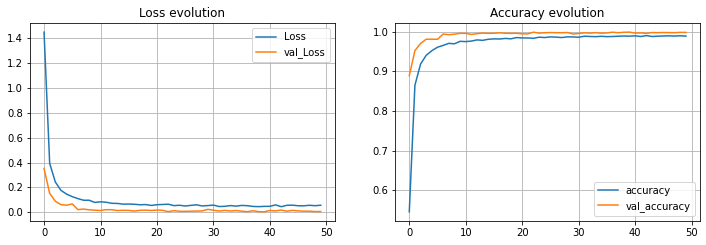

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

In [ ]:
X_train = None

In [ ]:
predicted = model.predict(X_test)

In [ ]:
print(y_test.shape, predicted.shape)
print(y_test[0], predicted[0])

(10900, 29) (10900, 29)
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [5.3513946e-14 4.3078944e-15 3.2866728e-24 4.3303281e-18 1.0000000e+00
 3.2987882e-20 2.3732031e-19 7.4242366e-29 1.3136213e-10 7.2186030e-23
 2.0209414e-23 1.4216502e-22 1.0688946e-20 2.6858422e-24 3.2645695e-16
 3.6038750e-29 2.0342289e-31 8.6286582e-25 1.3926306e-14 1.3632623e-20
 7.7313664e-20 2.6605933e-24 1.8466347e-23 9.7790681e-20 6.8779811e-31
 1.8436869e-29 3.8072060e-29 2.9487732e-25 6.1506830e-29]


In [ ]:
for i in range(len(predicted)):
  predicted[i][np.where(predicted[i]==np.max(predicted[i]))] = 1
  predicted[i][np.where(predicted[i]!=np.max(predicted[i]))] = 0
print(predicted[0])


[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


In [ ]:
cm = metrics.confusion_matrix(y_test.argmax(axis=1), predicted.argmax(axis=1))

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

# Visualizing
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

In [ ]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space' ]

Confusion matrix, without normalization


<Figure size 1440x1440 with 0 Axes>

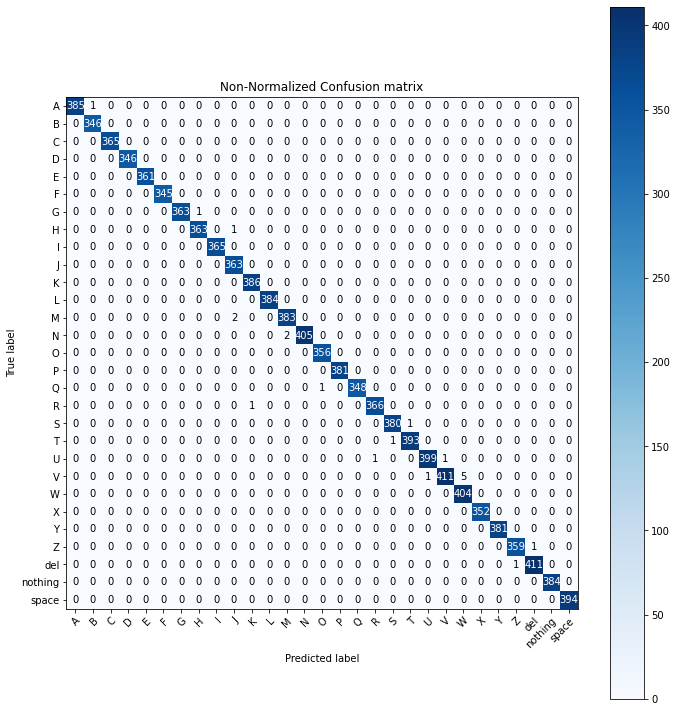

In [ ]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(y_test.argmax(axis=1), predicted.argmax(axis=1), classes = labels, title='Non-Normalized Confusion matrix')
plt.show()

Normalized confusion matrix


<Figure size 3600x2520 with 0 Axes>

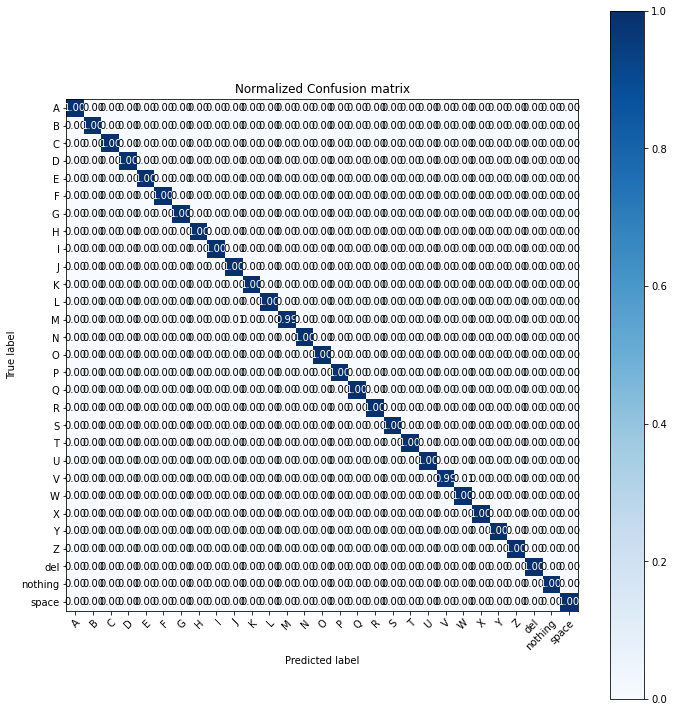

In [ ]:
plt.figure(figsize=(50,35))
plot_confusion_matrix(y_test.argmax(axis=1), predicted.argmax(axis=1), classes = labels, normalize=True, title='Normalized Confusion matrix')
plt.show()

In [ ]:
from google.colab import files
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
files.download('model.json')
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_info = pd.read_csv(TESTING_INFO)

In [ ]:
pd.concat([test_info.head(), test_info.tail()])

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg
26095,Image_26096.jpg
26096,Image_26097.jpg
26097,Image_26098.jpg
26098,Image_26099.jpg
26099,Image_26100.jpg


In [ ]:
X_test_csv = test_info[['filename']].to_numpy().reshape(-1,)
print(len(X_test_csv))

26100


In [ ]:
def images_to_array_test(DIRECTORY, SIZE):
    images = np.zeros(SIZE)
    for idx, image in enumerate(X_test_csv):
        path = os.path.join(DIRECTORY, image)
        image = cv2.imread(path, 0)
        image = cv2.resize(image, (SIZE[1], SIZE[2]), interpolation=cv2.INTER_AREA)
        image = image.reshape(SIZE[1], SIZE[2], 1)
        images[idx, :, :, :] = image/255.0
    return images

In [ ]:
val_size = (26100, 100, 100, 1)
X_val = images_to_array_test(TESTING_DIR, val_size)

In [ ]:
y_val_predicted = model.predict(X_val)

In [ ]:
print(y_val_predicted[0])

[1.09e-16 3.32e-16 5.14e-27 5.91e-22 2.48e-20 1.91e-24 1.79e-25 4.69e-28
 9.75e-16 7.74e-21 4.23e-15 1.33e-14 1.00e+00 2.84e-12 1.06e-13 4.58e-27
 5.02e-36 2.41e-18 1.68e-18 7.02e-17 1.67e-13 1.58e-13 7.46e-12 1.04e-19
 3.35e-19 3.29e-17 2.80e-27 1.59e-25 8.96e-24]


In [ ]:
for i in range(len(y_val_predicted)):
  y_val_predicted[i] = np.argmax(y_val_predicted[i])

In [ ]:
y_val_predicted[0]

array([12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12.], dtype=float32)

In [ ]:
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
predicted = []
for i in range(len(y_val_predicted)):
  temp = y_val_predicted[i][0]
  temp = 65+int(temp)
  if temp > 90:
    if temp == 91:
      temp = 'del'
    elif temp == 92:
      temp = 'nothing'
    else:
      temp = 'space'
  else:
    temp = chr(temp)
  predicted.append(temp)
print(predicted)

['M', 'G', 'I', 'E', 'D', 'nothing', 'F', 'P', 'N', 'K', 'K', 'J', 'W', 'B', 'nothing', 'H', 'V', 'T', 'Q', 'P', 'J', 'N', 'E', 'H', 'B', 'V', 'J', 'V', 'nothing', 'U', 'D', 'Z', 'T', 'C', 'I', 'del', 'Z', 'G', 'X', 'del', 'F', 'P', 'V', 'Y', 'P', 'G', 'D', 'M', 'L', 'V', 'space', 'R', 'F', 'B', 'H', 'W', 'M', 'D', 'nothing', 'C', 'space', 'F', 'G', 'E', 'I', 'D', 'C', 'P', 'E', 'M', 'S', 'G', 'Y', 'A', 'B', 'V', 'B', 'Z', 'X', 'del', 'M', 'B', 'P', 'C', 'B', 'V', 'P', 'del', 'G', 'M', 'N', 'M', 'K', 'nothing', 'Z', 'nothing', 'V', 'space', 'L', 'C', 'X', 'N', 'W', 'M', 'I', 'D', 'J', 'T', 'T', 'M', 'O', 'X', 'Y', 'C', 'M', 'I', 'Q', 'K', 'K', 'T', 'J', 'S', 'Z', 'B', 'F', 'C', 'Z', 'Q', 'I', 'B', 'H', 'Y', 'del', 'E', 'I', 'Z', 'Q', 'P', 'X', 'N', 'K', 'D', 'del', 'N', 'R', 'Z', 'I', 'B', 'K', 'I', 'D', 'space', 'S', 'T', 'Y', 'del', 'F', 'M', 'D', 'space', 'C', 'J', 'U', 'P', 'W', 'N', 'A', 'K', 'Z', 'D', 'del', 'S', 'S', 'L', 'R', 'X', 'nothing', 'O', 'J', 'T', 'E', 'W', 'N', 'C', '

In [ ]:
res = pd.DataFrame({'label': predicted})
res.to_csv('submissions.csv')

In [ ]:
from google.colab import files
files.download('asl_challenge.ipynb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>